In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import GPy
import pickle

plt.style.use('hfs')

def sampled_LC_params(t, V, alpha=0.01):
    _mag_interp=V
    _time_interp = t

    _ind_tmax=_mag_interp.argmax()
    t_max = _time_interp[_ind_tmax]
    ax1.plot(_time_interp, _mag_interp, c='k', label='GP', alpha=alpha)
    
    x_30_40 = np.atleast_2d(np.array([30, 40])).T
    mag_30_40, __ = m.predict(x_30_40)

    # DELTA MAG 40 30
    dm_40_30 = (mag_30_40[1]-mag_30_40[0])
    ax1.axvline(_time_interp[_ind_tmax],c='k', label='t_max', alpha=alpha)
    ax1.axvline(x_30_40[0],c='k', ls=':', alpha=alpha)
    ax1.axvline(x_30_40[1],c='k', ls=':', alpha=alpha)

    ### FIRST DERIVATIVE 
    grad1 = np.gradient(_mag_interp)[_ind_tmax:] # after max
    ax2.plot(_time_interp, np.gradient(_mag_interp),lw=1, color='r', ls='--', alpha=alpha)
    ax2.plot(_time_interp[_ind_tmax:], grad1, color='r', alpha=alpha)

    # need second derivative to get the maximum
    grad2 = np.gradient(grad1) # important to not cut V_interp otherwise fucked

    # this finds the locations where grad2 goes from positive to negative - indicating peaks in grad1
    argmax_grad1 = [False] + [True if grad2[i]<0 and grad2[i-1]>0  else False for i in np.arange(1,grad2.shape[0])]
    t_dm1 = _time_interp[_ind_tmax:][argmax_grad1][0]

    # plotting location of t_dm1
    ax2.axvline(t_dm1, c='darkred', lw=1, alpha=alpha)
    ax1.axvline(t_dm1, c='darkred',  ls=':',label='t_dm1', alpha=alpha)

    ### SECOND DERIVATIVE 
    ax3.plot(_time_interp[1:], np.gradient(np.gradient(_mag_interp))[1:],lw=1,  
             color='b', ls='--', alpha=alpha)
    ax3.plot(_time_interp[_ind_tmax:], grad2, color='b', alpha=alpha)
    grad3 = np.gradient(grad2)
    argmin_grad2 = [False] + [True if grad3[i]>0 and grad3[i-1]<0  else False for i in np.arange(1,grad3.shape[0])]
    t_dm2 = _time_interp[_ind_tmax:][argmin_grad2][0]
    ax3.axvline(t_dm2, c='cornflowerblue', lw=1, alpha=alpha)
    ax1.axvline(t_dm2, c='cornflowerblue', ls='--', label='t_dm2', alpha=alpha)
    
    return t_max, t_dm1-t_max, t_dm2-t_max, dm_40_30[0]


In [2]:
data = pd.read_csv('../Data/IIb_clean_sample.dat', index_col=0)
data.event.unique()

array(['SN2008ax', 'SN2011dh', 'SN1993J', 'SN2006T', 'SN2004ex',
       'SN2008aq', 'SN2013df', 'SN2006el'], dtype=object)

In [3]:
sn='SN2004ex'
data=data[data.event==sn].drop('event',axis=1)

In [4]:
results=pd.read_csv('params_best_GP_IIb.dat', index_col=0)

In [5]:
t_norm = data.MJD.values - data.texp.iloc[0]
t_exp = 0
y=np.atleast_2d(data.V).T
X=np.atleast_2d(t_norm).T

err = data.Verr.values

length_scale=200
variance=2
                 
k_rbf = GPy.kern.RBF(input_dim=1, variance=10, lengthscale=30)

k_bias =  GPy.kern.Bias(1, GPy.util.linalg.tdot(err))
k_lin = GPy.kern.Linear(input_dim=1)
#k_lin = GPy.kern.LinearSlopeBasisFuncKernel(input_dim=1, start=30, stop=80)
kernel = k_rbf + k_lin + k_bias

In [6]:
x=np.atleast_2d(np.linspace(t_norm.min(), t_norm.max(),200)).T

In [7]:
n=100

In [8]:
k_matern = GPy.kern.Matern32(input_dim=1)

In [9]:
k_rbf1 = GPy.kern.RBF(input_dim=1,  lengthscale=35)
k_rbf2 = GPy.kern.RBF(input_dim=1,  lengthscale=1)

In [10]:
m_rbf = GPy.models.GPRegression(X,y,k_rbf)
__ = m_rbf.optimize ()
__ = m_rbf.optimize_restarts (num_restarts = 500 , parallel = True, verbose = False)

In [11]:
m_matern = GPy.models.GPRegression(X,y,k_matern)
__ = m_matern.optimize ()
__ = m_matern.optimize_restarts (num_restarts = n , parallel = True, verbose = False)

In [12]:
m = GPy.models.GPRegression(X,y,k_rbf1+k_rbf2)
__ = m.optimize ()
__ = m.optimize_restarts (num_restarts = n , parallel = True, verbose = False)

 /home/fste075/.local/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /home/fste075/.local/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /home/fste075/.local/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /home/fste075/.local/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /home/fste075/.local/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply
 /home/fste075/.local/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /home/fste075/.local/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /home/fste075/.local/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


(20.0, 16.0)

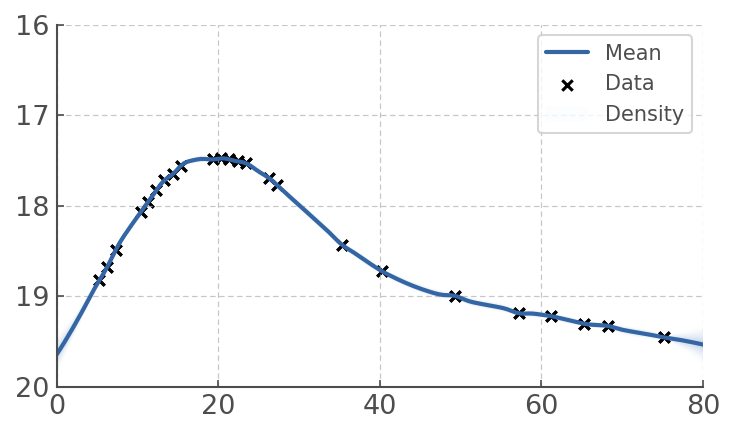

In [13]:
m.plot(plot_density=True)
plt.gca().invert_yaxis()
plt.xlim([0,80])
plt.ylim([20,16])

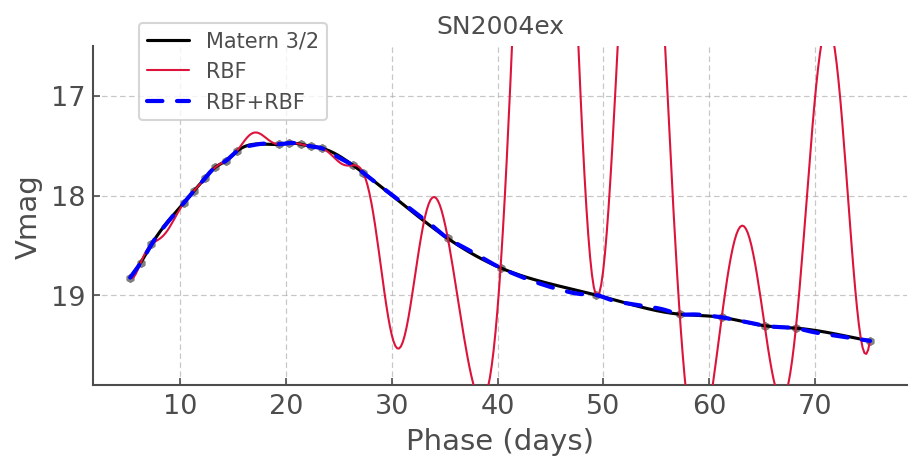

In [14]:
f, ax = plt.subplots(nrows=1, figsize=(7,3))

x=np.atleast_2d(np.linspace(t_norm.min(), t_norm.max(),400)).T

_time_interp = x.T[0]

_mag_interp0, sigma0 = m_rbf.predict(x)

_mag_interp1, sigma1 = m_matern.predict(x)

_mag_interp2, sigma2 = m.predict(x)

ax.plot(x, _mag_interp1, c='k', label='Matern 3/2')
ax.plot(x, _mag_interp0, c='crimson', zorder=20, lw=1, label='RBF')
ax.plot(x, _mag_interp2, c='blue', zorder=20, lw=2, ls='--', label='RBF+RBF')

ax.scatter(t_norm, y, color='grey', marker='h',s=10)
ax.invert_yaxis()
ax.set_ylim([19.9,16.5])

ax.set_ylabel('Vmag')
ax.set_xlabel('Phase (days)')
plt.title(f'{sn}',fontsize=12)
plt.legend(ncol=1,bbox_to_anchor=(0.5,0.75, -0.2, 0.0))
plt.savefig('04ex_gpy_kernels.png', bbox_inches='tight')

In [15]:
m_rbf

GP_regression.,value,constraints,priors
rbf.variance,189.20098489691907,+ve,
rbf.lengthscale,2.941741790361266,+ve,
Gaussian_noise.variance,6.0410311388199226e-55,+ve,


In [16]:
np.diff(data.MJD)

array([  0.99,   1.02,   3.09,   0.91,   1.04,   0.98,   1.02,   1.01,
         4.  ,   0.99,   1.05,   1.  ,   1.  ,   2.96,   0.97,   8.  ,
         4.98,   9.02,   7.92,   3.97,   4.06,   2.95,   7.01, -69.94,
         0.99,   1.02,   3.09,   0.91,   1.04,   0.98,   1.02,   1.01,
         4.  ,   0.99,   1.05,   1.  ,   1.  ,   2.96,   0.97,   8.  ,
         4.98,   9.02,   7.92,   3.97,   4.06,   2.95,   7.01])

In [17]:
m

GP_regression.,value,constraints,priors
sum.rbf.variance,0.0004397599494291478,+ve,
sum.rbf.lengthscale,0.8711394618650173,+ve,
sum.rbf_1.variance,194.5124119701558,+ve,
sum.rbf_1.lengthscale,27.816414375674174,+ve,
Gaussian_noise.variance,3.3453334871927715e-59,+ve,


In [18]:
_file = open(f'{sn}.gpym', 'wb')
pickle.dump(m, _file)
_file.close()

<ErrorbarContainer object of 3 artists>

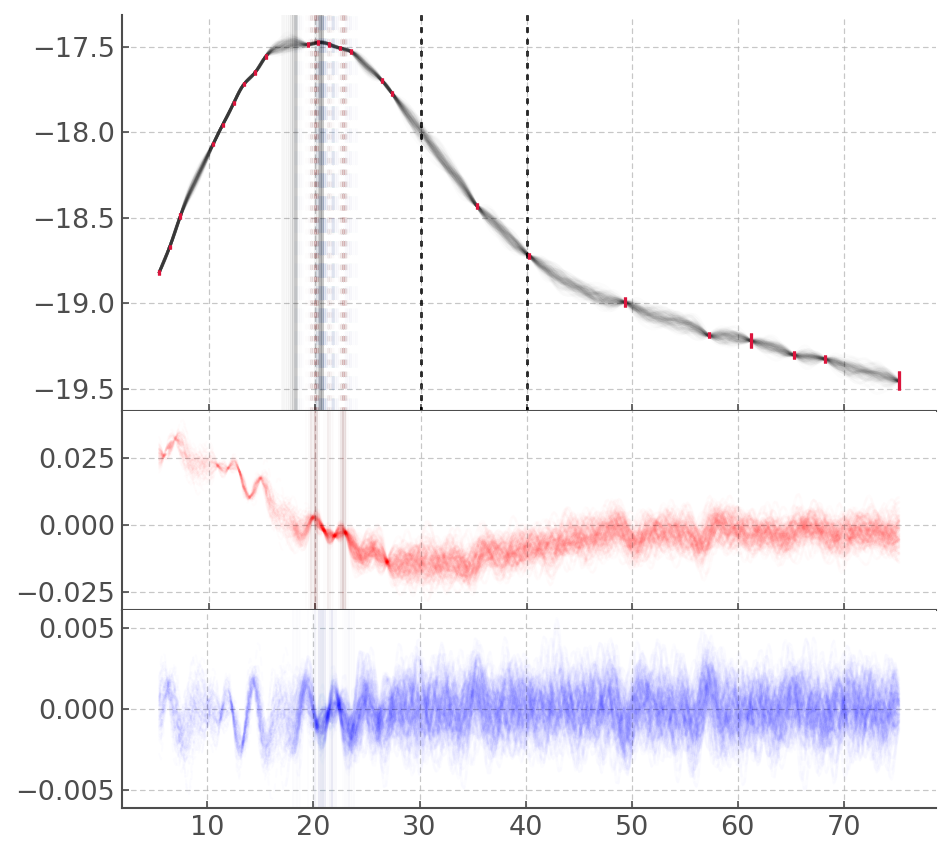

In [19]:
fig = plt.figure(figsize=(7,7))
gs = GridSpec(4, 4, hspace=0)
ax1 = fig.add_subplot(gs[:-2, :])
ax2 = fig.add_subplot(gs[2, :])
ax3 = fig.add_subplot(gs[3, :])


list_params = []

t = np.atleast_2d(np.linspace(t_norm.min(), t_norm.max(),400)).T

_mag_interp, sigma = m.predict(t, full_cov=True)
_mag_interp=_mag_interp[:,0]*-1

test = np.random.multivariate_normal(_mag_interp,  sigma, size=100)
for i in range(test.shape[0]):
    _v_i = test[i,:]
    _params = sampled_LC_params(t=t[:,0], V=_v_i, alpha=0.01)
    list_params.append(list(_params))
    
ax1.errorbar(data.MJD-data.texp.iloc[0], data.V*-1, yerr = data.Verr, ls=' ', zorder=1000, color='crimson')

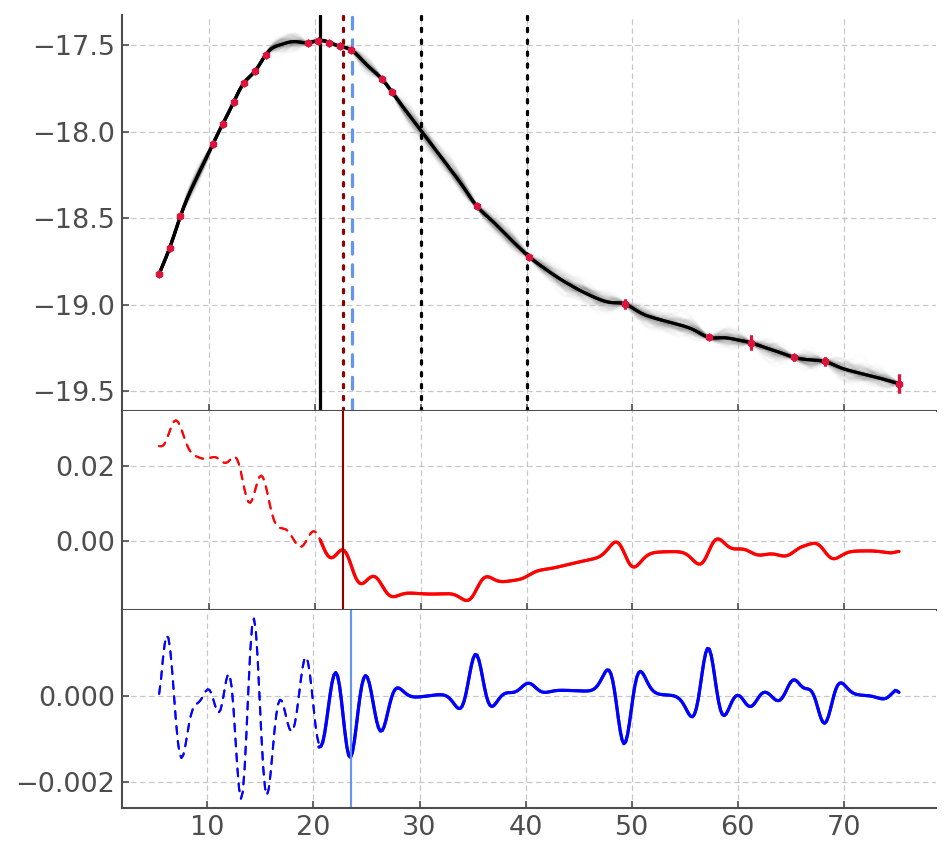

In [23]:
fig = plt.figure(figsize=(7,7))
gs = GridSpec(4, 4, hspace=0)
ax1 = fig.add_subplot(gs[:-2, :])
ax2 = fig.add_subplot(gs[2, :])
ax3 = fig.add_subplot(gs[3, :])

t = np.atleast_2d(np.linspace(t_norm.min(), t_norm.max(),400)).T

_mag_interp, sigma = m.predict(t, full_cov=True)
_mag_interp=_mag_interp[:,0]*-1

_params = sampled_LC_params(t=t[:,0], V=_mag_interp, alpha=0.9)
_params2 = sampled_LC_params(t=t[:,0], V=_mag_interp2, alpha=0.9)  
    
ax1.errorbar(data.MJD-data.texp.iloc[0], data.V*-1, yerr = data.Verr, ls=' ',
             zorder=1000, color='crimson', marker='h', markersize=4)

test = np.random.multivariate_normal(_mag_interp,  sigma, size=100)
for i in range(test.shape[0]):
    _v_i = test[i,:]
    ax1.plot(t[:,0], _v_i, alpha=0.01, c='k', zorder=0.1)

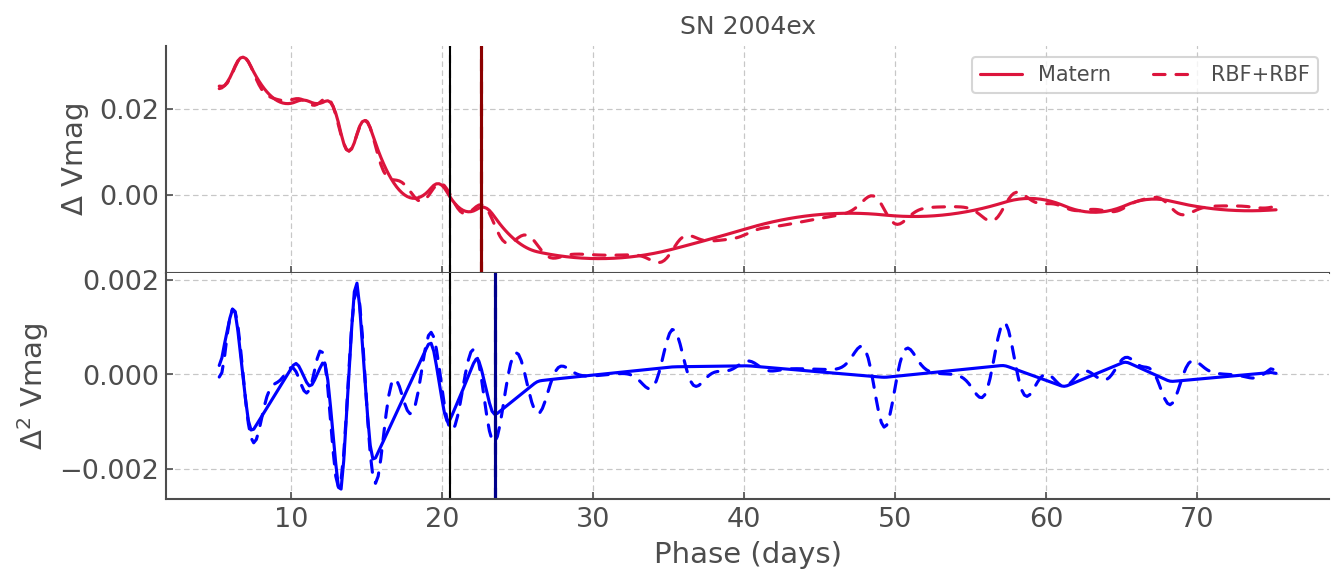

In [26]:
f, ax = plt.subplots(nrows=2, figsize=(10,4))
plt.subplots_adjust(hspace=0.0)
t = np.atleast_2d(np.linspace(t_norm.min(), t_norm.max(),400)).T

_mag_interp, sigma = m_matern.predict(t, full_cov=True)
_mag_interp=_mag_interp[:,0]*-1

_mag_interp2, sigma = m.predict(t, full_cov=True)
_mag_interp2=_mag_interp2[:,0]*-1

grad1_matern = np.gradient(_mag_interp)
grad2_matern = np.gradient(grad1_matern)

grad1_rbf_bias = np.gradient(_mag_interp2)
grad2_rbf_bias  = np.gradient(grad1_rbf_bias)


ax[0].plot(t, grad1_matern, color='crimson', label='Matern')
ax[0].plot(t, grad1_rbf_bias, color='crimson',ls='--', label='RBF+RBF')
ax[0].legend(ncol=2)
ax[0].axvline(_params[0], lw=1, color='k')
ax[0].axvline(_params2[0], lw=1, ls='--', color='k')
ax[0].axvline(_params[0]+_params[1], color='darkred')
ax[0].axvline(_params2[0]+_params2[1], ls='--', color='darkred')

ax[1].plot(t, grad2_matern, color='blue')
ax[1].plot(t, grad2_rbf_bias, color='blue',ls='--')
ax[1].axvline(_params[0], lw=1, color='k')
ax[1].axvline(_params2[0], lw=1, ls='--', color='k')
ax[1].axvline(_params[0]+_params[2], color='darkblue')
ax[1].axvline(_params2[0]+_params2[2], ls='--', color='darkblue')

ax[0].set_ylabel('$\Delta$ Vmag')
ax[1].set_ylabel('$\Delta^2$ Vmag')
ax[1].set_xlabel('Phase (days)')
ax[0].set_title('SN 2004ex', fontsize=12)

plt.savefig('SN2004ex_dm1dm2.png', bbox_inches='tight')

In [22]:
results.loc[sn].iloc[0] = data.texp.iloc[0]
results.loc[sn].iloc[1:] = _params
results.to_csv('params_best_GP_IIb.dat')

In [23]:
results

,texp,trise,dm1,dm2,dm4030
event,,,,,
SN2008ax,54528.30,20.012331,34.884962,42.030075,0.664096
SN2011dh,55712.40,18.502968,36.534687,41.649543,0.728440
SN1993J,49073.05,21.999624,29.261654,0.959398,0.648006
SN2006T,NaN,NaN,NaN,NaN,NaN
SN2004ex,53287.85,20.520075,2.103459,2.979900,0.717333
SN2008aq,NaN,NaN,NaN,NaN,NaN
SN2013df,56448.20,21.083333,35.666491,0.406842,0.728019
SN2006el,53959.00,24.599014,46.591593,55.909912,0.582495


In [24]:
results

,texp,trise,dm1,dm2,dm4030
event,,,,,
SN2008ax,54528.30,20.012331,34.884962,42.030075,0.664096
SN2011dh,55712.40,18.502968,36.534687,41.649543,0.728440
SN1993J,49073.05,21.999624,29.261654,0.959398,0.648006
SN2006T,NaN,NaN,NaN,NaN,NaN
SN2004ex,53287.85,20.520075,2.103459,2.979900,0.717333
SN2008aq,NaN,NaN,NaN,NaN,NaN
SN2013df,56448.20,21.083333,35.666491,0.406842,0.728019
SN2006el,53959.00,24.599014,46.591593,55.909912,0.582495


# Fitting with sklearn

In [25]:
from sklearn import gaussian_process as sklgp


def sampled_LC_params(m, t, alpha=0.01, ax1 = None, ax2 = None, ax3 = None, size=100):
    
    try:
        _mag_interp, sigma = m.predict(t, full_cov=True) # GPy implementation
        _mag_interp=_mag_interp[:,0]*-1
    except TypeError:
        _mag_interp, sigma = m.predict(t, return_cov=True) # sklearn implementation
        _mag_interp=_mag_interp*-1
    
    _time_interp = t[:,0]

    _ind_tmax=_mag_interp.argmax()
    t_max = _time_interp[_ind_tmax]

    ax1.plot(_time_interp, _mag_interp*-1, c='k', label='GP', alpha=alpha, zorder=10000)
    
    
    x_30 = np.atleast_2d(np.array([30])).T
    x_40 = np.atleast_2d(np.array([40])).T

    mag_30 =  m.predict(x_30)
    mag_40 =  m.predict(x_40)

    # DELTA MAG 40 30
    dm_40_30 = (mag_40-mag_30)
    ax1.axvline(_time_interp[_ind_tmax],c='grey', lw=1, alpha=alpha, label='t$_{max}$')
    ax1.axvline(x_30,c='k', ls=':', alpha=0.5, label='+30 days')
    ax1.axvline(x_40,c='k', ls=':', alpha=0.8, label='+40 days')

    ### FIRST DERIVATIVE 
    grad1 = np.gradient(_mag_interp)[_ind_tmax:] # after max
    ax2.plot(_time_interp, np.gradient(_mag_interp),lw=1, color='r', ls='--', alpha=alpha)
    ax2.plot(_time_interp[_ind_tmax:], grad1, color='r', alpha=alpha)

    # need second derivative to get the maximum
    grad2 = np.gradient(grad1) # important to not cut V_interp otherwise fucked

    # this finds the locations where grad2 goes from positive to negative - indicating peaks in grad1
    argmax_grad1 = [False] + [True if grad2[i]<0 and grad2[i-1]>0  else False for i in np.arange(1,grad2.shape[0])]
    t_dm1 = _time_interp[_ind_tmax:][argmax_grad1][0]

    # plotting location of t_dm1
    ax2.axvline(t_dm1, c='darkred', lw=1, alpha=alpha)
    ax1.axvline(t_dm1, c='darkred',  ls=':', alpha=alpha, label='dm1')

    ### SECOND DERIVATIVE 
    ax3.plot(_time_interp[1:], np.gradient(np.gradient(_mag_interp))[1:],lw=1,  
             color='b', ls='--', alpha=alpha)
    ax3.plot(_time_interp[_ind_tmax:], grad2, color='b', alpha=alpha)
    grad3 = np.gradient(grad2)
    argmin_grad2 = [False] + [True if grad3[i]>0 and grad3[i-1]<0  else False for i in np.arange(1,grad3.shape[0])]
    t_dm2 = _time_interp[_ind_tmax:][argmin_grad2][0]
    ax3.axvline(t_dm2, c='cornflowerblue', lw=1, alpha=alpha)
    ax1.axvline(t_dm2, c='cornflowerblue', ls='--',  alpha=alpha, label='dm2')
    
    ## Sampling to show uncertianties
    test = np.random.multivariate_normal(_mag_interp,  sigma, size=size)
    for i in range(test.shape[0]):
        _v_i = test[i,:]
        ax1.plot(_time_interp , _v_i*-1, alpha=0.01, zorder=0.1, color='k')
        _grad1 = np.gradient(_v_i)
        ax2.plot(_time_interp, _grad1, color='r', alpha=0.01)
        _grad2 = np.gradient(_grad1)
        ax3.plot(_time_interp, _grad2, color='b', alpha=0.01)
    
    return t_max, t_dm1-t_max, t_dm2-t_max, dm_40_30[0]

In [26]:
results_SKL=pd.read_csv('params_best_GP_IIb_SKL.dat', index_col=0)

In [27]:
t_norm = data.MJD.values - data.texp.iloc[0]
t_exp = 0

y=data.V.values
X=np.atleast_2d(t_norm.astype(float)).T
                 
k_rbf = sklgp.kernels.RBF(length_scale_bounds=(10,100)) 
k_rq = sklgp.kernels.RationalQuadratic(length_scale_bounds=(1,20)) 
k_white = sklgp.kernels.WhiteKernel(noise_level_bounds=(1e-07, 100))
k_matern = sklgp.kernels.Matern(nu=1.5)

In [28]:
k1 = sklgp.kernels.RationalQuadratic(length_scale=35) 
k2 = sklgp.kernels.RationalQuadratic(length_scale=1) 
kernel=k1+k2

In [29]:
gp = sklgp.GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=100, normalize_y=False)
gp.fit(X, y)

 /home/fste075/.local/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning:lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


GaussianProcessRegressor(kernel=RationalQuadratic(alpha=1, length_scale=35) + RationalQuadratic(alpha=1, length_scale=1),
                         n_restarts_optimizer=100)

there was a sklearn `AttributeError: 'str' object has no attribute 'decode'` bug introduced by scipy - reverting to 1.5.3 worked - not sure why it appeared here and not in all jupyter notebooks - maybe slightly different data object that triggered different codes

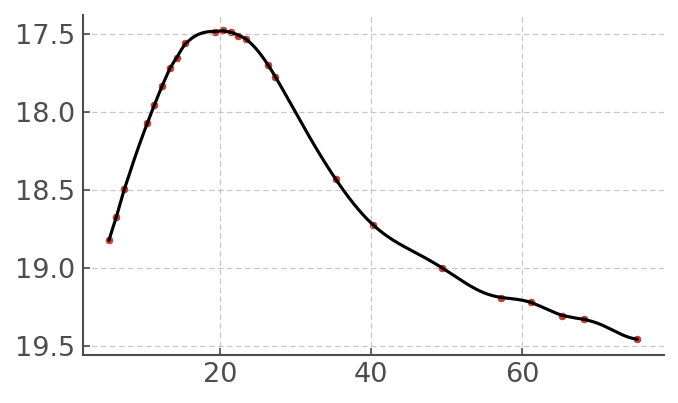

In [30]:
x=np.atleast_2d(np.linspace(t_norm.min(), t_norm.max(),400)).T
_mag_interp, sigma = gp.predict(x, return_std=True)
_time_interp = x.T[0]
    
plt.plot(x, _mag_interp, c='k', label='GP')
plt.scatter(t_norm, data.V, label='data')
plt.gca().invert_yaxis()

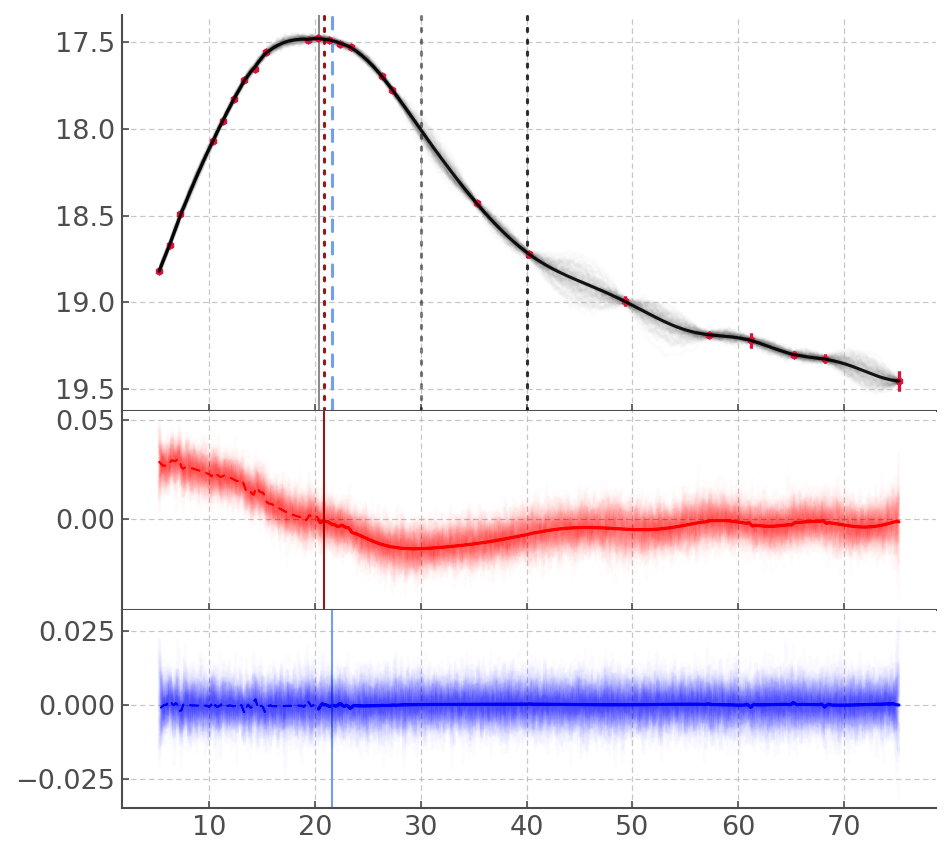

In [31]:
fig = plt.figure(figsize=(7,7))
gs = GridSpec(4, 4, hspace=0)
ax1 = fig.add_subplot(gs[:-2, :])
ax2 = fig.add_subplot(gs[2, :])
ax3 = fig.add_subplot(gs[3, :])

t = np.atleast_2d(np.linspace(t_norm.min(), t_norm.max(),400)).T

_mag_interp, sigma = gp.predict(x, return_cov=True)
_time_interp = x.T[0]

_mag_interp=_mag_interp[:]

_params = sampled_LC_params(t=t, m=gp, alpha=0.9, ax1=ax1, ax2=ax2, ax3=ax3)
    
ax1.errorbar(data.MJD-data.texp.iloc[0], data.V, yerr = data.Verr, ls=' ',
             zorder=1000, color='crimson', marker='h', markersize=4)

ax1.invert_yaxis()

In [32]:
results_SKL.loc[sn].iloc[0] = data.texp.iloc[0]
results_SKL.loc[sn].iloc[1:] = _params
results_SKL.to_csv('params_best_GP_IIb_SKL.dat')

In [33]:
results

,texp,trise,dm1,dm2,dm4030
event,,,,,
SN2008ax,54528.30,20.012331,34.884962,42.030075,0.664096
SN2011dh,55712.40,18.502968,36.534687,41.649543,0.728440
SN1993J,49073.05,21.999624,29.261654,0.959398,0.648006
SN2006T,NaN,NaN,NaN,NaN,NaN
SN2004ex,53287.85,20.520075,2.103459,2.979900,0.717333
SN2008aq,NaN,NaN,NaN,NaN,NaN
SN2013df,56448.20,21.083333,35.666491,0.406842,0.728019
SN2006el,53959.00,24.599014,46.591593,55.909912,0.582495


In [34]:
results_SKL

,texp,trise,dm1,dm2,dm4030
event,,,,,
SN2008ax,54528.30,21.693534,3.782707,0.840602,0.641308
SN2011dh,55712.40,20.512376,19.728731,1.826734,0.649846
SN1993J,49073.05,22.198622,11.912782,1.635088,0.658547
SN2006T,NaN,NaN,NaN,NaN,NaN
SN2004ex,53287.85,20.344787,0.525865,1.227018,0.707156
SN2008aq,NaN,NaN,NaN,NaN,NaN
SN2013df,56448.20,21.047343,24.915789,0.263659,0.730704
SN2006el,53959.00,23.933420,46.924390,56.242709,0.608721
